In [23]:
import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import numpy as np
import loadquakes

(-69.76659396852207, 83.1451271636401)
402
401


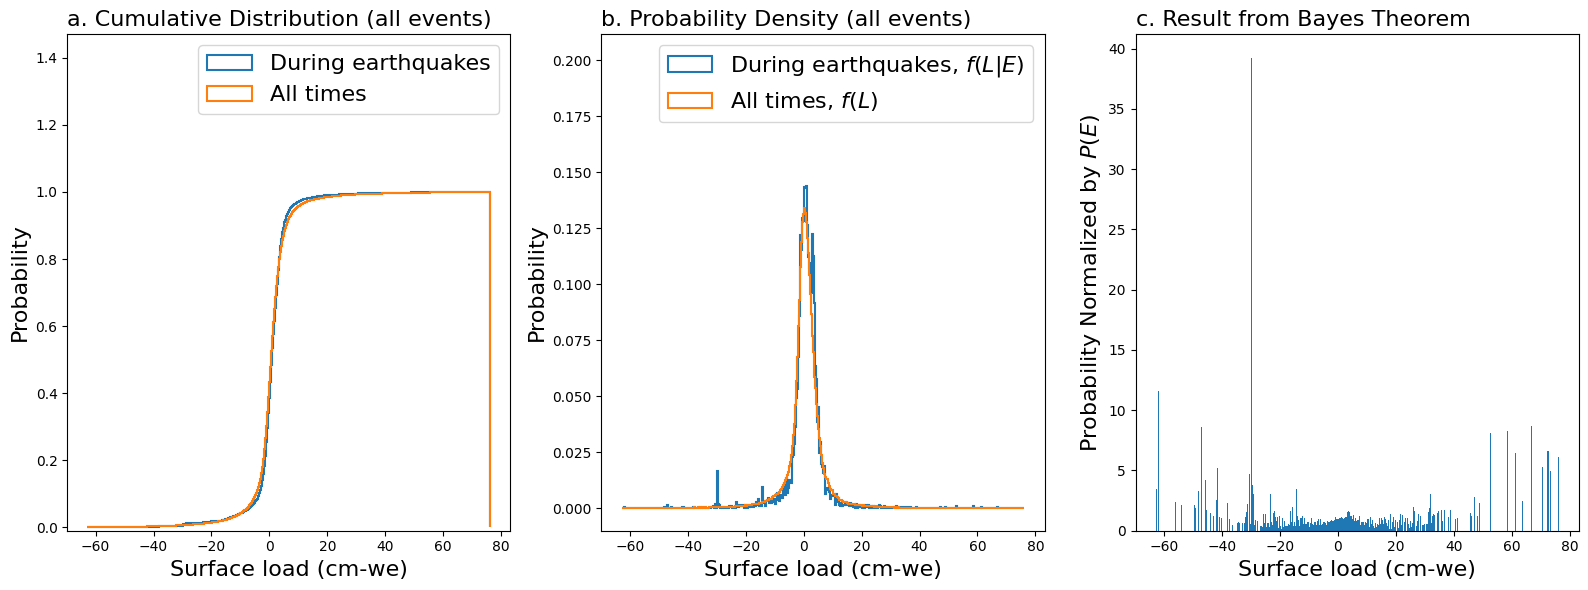

In [2]:
dataset_path = '/data/fast1/surface-load/' # GRACE data
grace_data = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202201.GLO.RL06M.MSCNv02CRI.nc")
catalog = pd.read_csv('catalog.csv')

all_loads=grace_data['lwe_thickness'].data.flatten()
full_catalog=catalog.dmass
method='fd'

fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,6))
loadquakes.plot_hist(all_loads, full_catalog, ax1, ax2, 
            'a. Cumulative Distribution (all events)', 'b. Probability Density (all events)', method)

loadquakes.plot_bayes(all_loads, full_catalog, ax3, 'c. Result from Bayes Theorem', method)

fig.tight_layout()
plt.show()
    

In [ ]:


def generate_synthetic_catalog(n=1000, seed=42,dmass_threshold=1,grace_data=grace_data):
    """
    Generate a synthetic earthquake catalog DataFrame.

    Parameters:
    - n: Number of synthetic events.
    - seed: Random seed for reproducibility.
    - dmass_threshold: Throw away events with dmass below this threshold.

    Returns:
    - GeoDataFrame with synthetic earthquake data.
    """
    np.random.seed(seed)

    # Random latitude [-90, 90], longitude [-180, 180]
    latitudes = np.random.uniform(-90, 90, size=n)
    longitudes = np.random.uniform(-180, 180, size=n)

    # Random times between 2002-04-16 and 2022-01-16
    start_date = pd.Timestamp("2002-04-16")
    end_date = pd.Timestamp("2022-01-16")
    timestamps = pd.to_datetime(
        np.random.randint(start_date.value // 10**9, end_date.value // 10**9, size=n), unit='s'
    )

    # Random magnitudes [0, 9]
    magnitudes = np.random.uniform(0, 9, size=n)

    # Generate geometry from lat/lon
    geometry = [Point(xy) for xy in zip(longitudes, latitudes)]

    # Create DataFrame
    df = pd.DataFrame({
        'latitude': latitudes,
        'longitude': longitudes,
        'time': timestamps,
    })

    # Read dmass from the GRACE dataset
    def get_mass(eq):
        mass_change = grace_data.sel(lat=(eq["latitude"]),
                                     lon=(eq["longitude"]),
                                     time=(eq["time"]), 
                                     method="nearest")
        mass_change = mass_change["lwe_thickness"]
        return mass_change.data
    
    # Drop rows where dmass is below the threshold
    dmass = df.apply(lambda row: get_mass(row), axis=1)

    # Boolean mask: True if abs(dmass) >= threshold
    mask_strict = np.abs(dmass) >= dmass_threshold

    # For those that don't meet the threshold, randomly accept with probability p
    # p=0.5
    # mask_soft = np.random.rand(len(dmass)) < p

    # # Final mask: keep if either strict or soft condition is met
    # mask = mask_strict | (~mask_strict & mask_soft)

    latitudes = latitudes[mask]
    longitudes = longitudes[mask]
    timestamps = timestamps[mask]
    dmass = dmass[mask]

    geometry = np.array(geometry)[mask]

    # Updated dataframe with filtered values
    df = pd.DataFrame({
        'latitude': latitudes,
        'longitude': longitudes,
        'time': timestamps,
        'dmass': dmass
    })

    # Add geometry column and convert to GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry)
    gdf.set_crs(epsg=4326, inplace=True)

    return gdf


<Axes: >

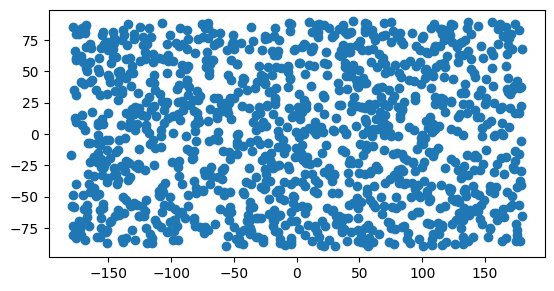

In [47]:
catalog_synthetic = generate_synthetic_catalog(n=1200,dmass_threshold=0)
catalog_synthetic.plot()

(-48.19503517499645, 68.07644301271972)
119
118


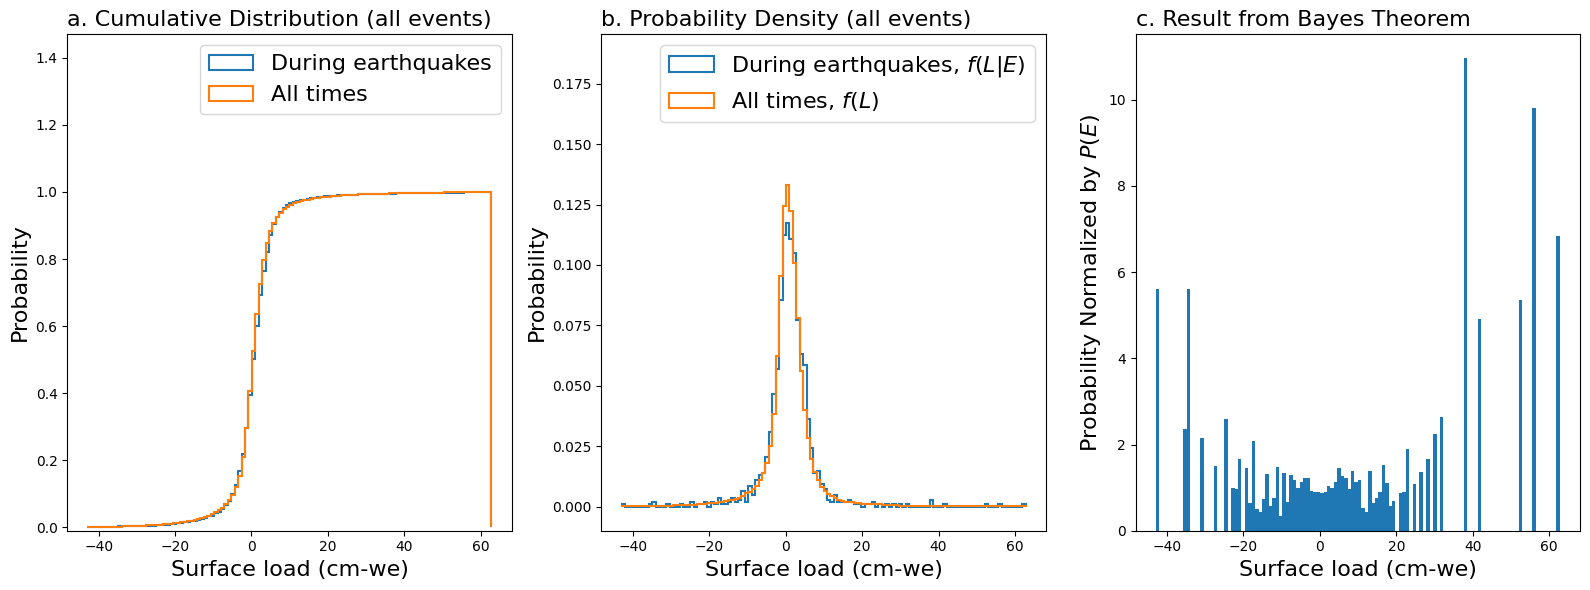

In [48]:
all_loads=grace_data['lwe_thickness'].data.flatten()
full_catalog=catalog_synthetic.dmass
method='fd'

fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(16,6))
loadquakes.plot_hist(all_loads, full_catalog, ax1, ax2, 
            'a. Cumulative Distribution (all events)', 'b. Probability Density (all events)', method)

loadquakes.plot_bayes(all_loads, full_catalog, ax3, 'c. Result from Bayes Theorem', method)

fig.tight_layout()
plt.show()